In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
%matplotlib inline

import sys

sys.path.append('../')
import src.read_raw as rr

In [2]:
with open('../playground/cfcme.dat','r') as f:
    files = [x.strip() for x in f]
df = rr.combine_files(files,io='I')
df = rr.realign(df)

In [14]:
print df.orbit.unique()

orb_colors = {'824':'orange','823':'r','822':'maroon','821':'c','820':'b','819':'purple','818':'k'}

[817 818 819 820 821 823 824 825 826 827 828 829 830]


In [5]:
import scipy.integrate as spi
import scipy.stats as sps
def exo_Ar_int(CO2,alt,exsp=['CO2'],ArXsec=[3.e-15],\
           Ntop=[0.,0.],taufrange=[0.5,1.5]):
    '''
    Calculate exobase altitude from species profiles
    (BE SURE TO USE INBOUND)
    Integrates down from some initial altitude to periapse
    Determines where num_density*coll_x-sec = 1 for exo altitude

    Inputs
    ------
    exsp: list, species to use in calculation
    ArXsec: list, collisional cross section for each species in exsp
    Ntop: list, column density above top for each species

    Outputs
    -------
    exo: float, exobase altitude
    fitTau: fit parameters of Tau profile (see scipy.stats.linregress)


    **TO DO:
    cite cross section values, should extrapolate ones that don't reac tau=1
    '''
    #convert alts to cm
    #orb_df = orb_df[orb_df['abundance_CO2']>0]
    xsec = dict(zip(exsp,ArXsec))
    altkm = np.array(alt)*1.e+5
    Tau_sp_dz = np.zeros((len(exsp),len(altkm)))  #initialize Tau/z
    for i,s in enumerate(xsec): #loop through species to use
        #colname = 'abundance_'+s
        #if colname in orb_df.columns: #check given species in DF
        Tau_sp_dz[i] = CO2*xsec[s] #calc n*sigma
        #else:
        #    print 'has no column '+colname
        #    return np.NaN
    Tau_tot_dz = np.sum(Tau_sp_dz,axis=0) #add each sp n*sigma together
    Tau_int = spi.cumtrapz(Tau_tot_dz,altkm*-1) #n*dz*sigma=N*sigma=Tau
    altmids = ((altkm[1:] + altkm[:-1]) / 2)/1.e+5 #gid mid alts in km
    findTau1 = np.where((Tau_int>taufrange[0])&(Tau_int<taufrange[-1])) #cond to find Tau=1
    if len(Tau_int[findTau1])<5: #warn if fitting line to only a few pts
        if np.max(Tau_int) < 1.0:
            print 'Never reaches tau=1, <'+str(int(altmids[-1]))+'?'
            return np.NaN, (np.NaN,np.NaN,np.NaN,np.NaN,np.NaN)
        else:
            print 'Has <5 points near tau=1'
            return np.NaN, (np.NaN,np.NaN,np.NaN,np.NaN,np.NaN)
    fitTau = sps.linregress(altmids[findTau1],Tau_int[findTau1])
    exo = (1-fitTau[1])/fitTau[0] #find alt where Tau=1
    return exo,fitTau #return exobase altitude
    

In [7]:
g = 3.81 #m/s^2 surface gravity
M_Mars =  0.64171e+24 #kg
R_Mars = 3396.2e+3 #m
Grav = 6.67408e-11 #m^3 kg^-1 s^-2
amu = 1.660539040e-27 #kg
kboltz = 1.38064852e-23 #J/K
def x_to_T(slope,mass):
    '''
    Convert slope of log of density (from fit) to a temperature.
    The slope is the negative recipricol of the scale height

    Inputs
    ------
    slope:
    mass: atmoic (amu)

    Outputs
    -------
    T: Temperature in Kelvin
    '''
    g = 3.71/1000 #km/s^2
    kboltzkm = kboltz/1000**2 #boltzmann constant (km^2 kg s^-2 K^-1)
    return (slope**-1*-1)*(mass*amu*g/kboltzkm)

In [172]:
exodf = df[df['alt']<250]
exo = {'orbit':[],'alts':[],'sg':[]}
exo_sg = [],[]
t_Ar = []
for i,[orb,orbdata] in enumerate(exodf.groupby('orbit')):
    exo['orbit'].append(orb)
    exob = exo_Ar_int(orbdata['abundance_CO2'],orbdata['alt'])[0]
    exo['alts'].append(exob)
    sg_CO2 = rr.savgol_density(orbdata['abundance_CO2'])
    sg_Ar = rr.savgol_density(orbdata['abundance_Ar'])
    exo['sg'].append(exo_Ar_int(sg_CO2,orbdata['alt']))

In [32]:
cf_df = df[(df['orbit']>=818)&(df['orbit']<=824)]

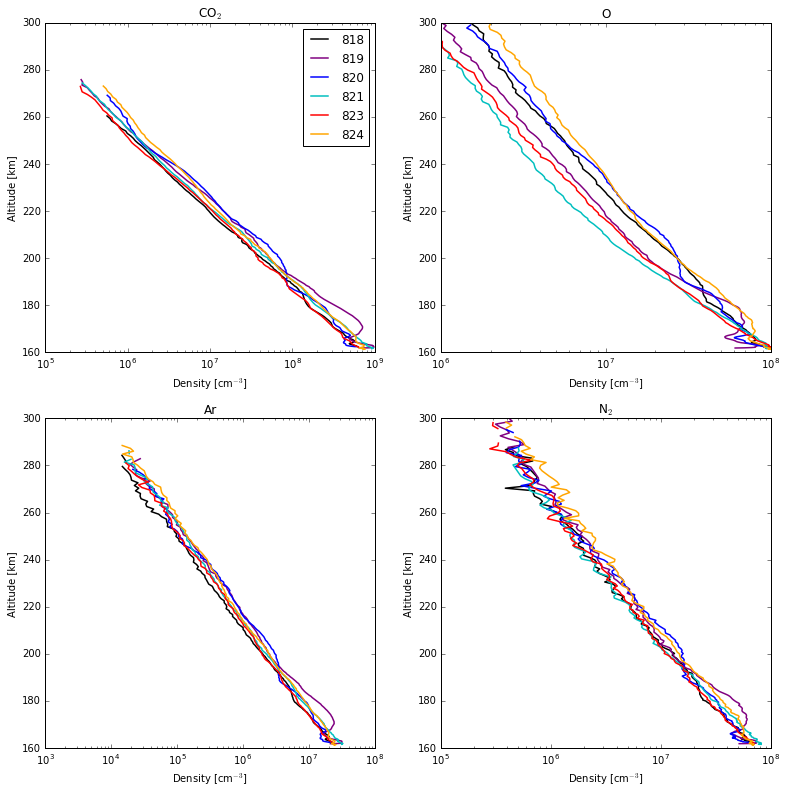

In [205]:
den_fig, den_ax = plt.subplots(2,2,figsize=(13,13))

for i,[orb,orbdata] in enumerate(cf_df.groupby('orbit')):
    if str(orb) in orb_colors.keys():
        cs = orb_colors[str(orb)]
        lw = 1.5
    else:
        cs = 'gray'
        lw=1
    
    co2 = den_ax[0,0].plot(orbdata['abundance_CO2'],orbdata['alt'],c=cs,lw=lw,label=str(orb))
    o = den_ax[0,1].plot(orbdata['abundance_O'],orbdata['alt'],c=cs,lw=lw,label=str(orb))
    ar = den_ax[1,0].plot(orbdata['abundance_Ar'],orbdata['alt'],c=cs,lw=lw,label=str(orb))
    n2 = den_ax[1,1].plot(orbdata['abundance_N2'],orbdata['alt'],c=cs,lw=lw,label=str(orb))
        

# SHARED
for ax in den_ax.flatten():
    # X-AXIS
    ax.set_xscale('log')
    ax.set_xlabel(r'Density [cm$^{-3}$]')

    # Y-AXIS
    ax.set_ylabel('Altitude [km]')
    ax.set_ylim(160,300)
    
# CO2
den_ax[0,0].set_title(r'CO$_2$')
den_ax[0,0].set_xlim(1.e+5,1.e+9)
den_ax[0,0].legend(loc=0)

# O
den_ax[0,1].set_title(r'O')
den_ax[0,1].set_xlim(1.e+6,1.e+8)

# Ar
den_ax[1,0].set_title(r'Ar')
den_ax[1,0].set_xlim(1.e+3,1.e+8)

# N2
den_ax[1,1].set_title(r'N$_2$')
den_ax[1,1].set_xlim(1.e+5,1.e+8)

den_fig.subplots_adjust(hspace=0.2)

#plt.savefig('../cme_densities.png',dpi=500)

plt.show()

In [179]:
cf_df_Ar  = cf_df[['orbit','alt','abundance_Ar']]
orbT = {'orbit':[],'temp':[]}
for i,[orb,orbdata] in enumerate(df.groupby('orbit')):
    Arorbdf = orbdata[['alt','abundance_Ar']][(orbdata['alt']<260)&(orbdata['alt']>180)].sort_values('alt')
    fit = sps.linregress(Arorbdf['alt'],np.log(Arorbdf['abundance_Ar']))
    orbT['temp'].append(x_to_T(fit[0],40)), orbT['orbit'].append(orb)
orbT = pd.DataFrame(orbT)

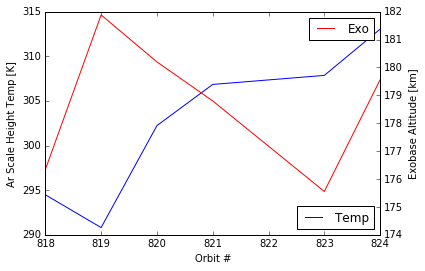

In [199]:
plt.figure()
plt.plot(orbT['orbit'],orbT['temp'],label='Temp')
plt.legend(loc=4)
plt.xlabel('Orbit #')
plt.ylabel('Ar Scale Height Temp [K]')
plt.ylim(290,315)
plt.twinx()
plt.plot(exo['orbit'],exo['alts'],'r',label='Exo')
plt.ylabel('Exobase Altitude [km]')
plt.ylim(174,182)
plt.xlim(818,824)
plt.legend()
plt.show()

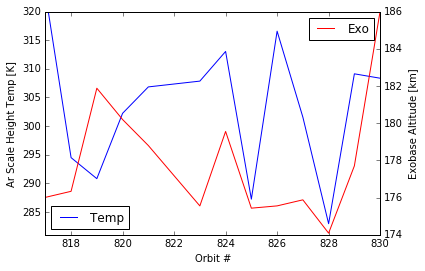

In [208]:
plt.figure()
plt.plot(orbT['orbit'],orbT['temp'],label='Temp')
plt.legend(loc=3)
plt.xlabel('Orbit #')
plt.ylabel('Ar Scale Height Temp [K]')
plt.ylim(281,320)
plt.twinx()
plt.plot(exo['orbit'],exo['alts'],'r',label='Exo')
plt.ylabel('Exobase Altitude [km]')
plt.ylim(174,186)
plt.xlim(817,830)
plt.legend()
#plt.savefig('../cme_exo_temp.png',dpi=300)
plt.show()

In [100]:
bins = np.arange(160,300,5)
bin_mid = (bins[1:]+bins[:-1])/2.

pieces = []
species = ['Ar','N2','CO2','O']
for i,[orb,orbdata] in enumerate(cf_df[cf_df['orbit']>=823].groupby('orbit')):
    binned = pd.cut(orbdata['alt'],bins,labels=bin_mid)
    bin_mean = orbdata[['abundance_'+s for s in species]].groupby(binned).mean()
    bin_std = orbdata[['abundance_'+s for s in species]].groupby(binned).std()
    agg = pd.merge(bin_mean.reset_index(),bin_std.reset_index(),on='alt',suffixes=['_mean_'+str(orb),'_std_'+str(orb)])
    pieces.append(agg)
indmeans = pd.concat(pieces,axis=1)

In [150]:
df_b4 = cf_df[(cf_df['orbit']<823)][['abundance_'+s for s in species]+['alt']].copy()
df_b4['bin_alt'] = pd.cut(df_b4['alt'],bins,labels=bin_mid)
b4_mean = df_b4.groupby('bin_alt').mean()
b4_std = df_b4.groupby('bin_alt').std()
b4means = pd.merge(b4_mean.reset_index(),b4_std.reset_index(),on='bin_alt',suffixes=['_mean','_std'])
b4means.head()

,bin_alt,abundance_Ar_mean,abundance_N2_mean,abundance_CO2_mean,abundance_O_mean,alt_mean,abundance_Ar_std,abundance_N2_std,abundance_CO2_std,abundance_O_std,alt_std
0,162.5,2.325077e+07,6.499804e+07,6.676958e+08,8.589432e+07,162.746227,4.971163e+06,9.502865e+06,1.606774e+08,1.047461e+07,0.861085
1,167.5,1.790207e+07,5.255036e+07,5.049008e+08,6.995349e+07,167.290074,2.789993e+06,6.286258e+06,8.771324e+07,8.990659e+06,1.425156
2,172.5,1.515378e+07,4.716419e+07,4.180354e+08,6.329666e+07,172.347873,4.816476e+06,8.443974e+06,1.499087e+08,4.358617e+06,1.463726
3,177.5,1.087251e+07,3.831295e+07,2.850127e+08,5.348654e+07,177.426259,3.760561e+06,9.215672e+06,1.032037e+08,7.714332e+06,1.474135
4,182.5,7.386608e+06,2.981645e+07,1.843885e+08,4.339039e+07,182.497098,2.102100e+06,7.232984e+06,5.061967e+07,7.467493e+06,1.481699


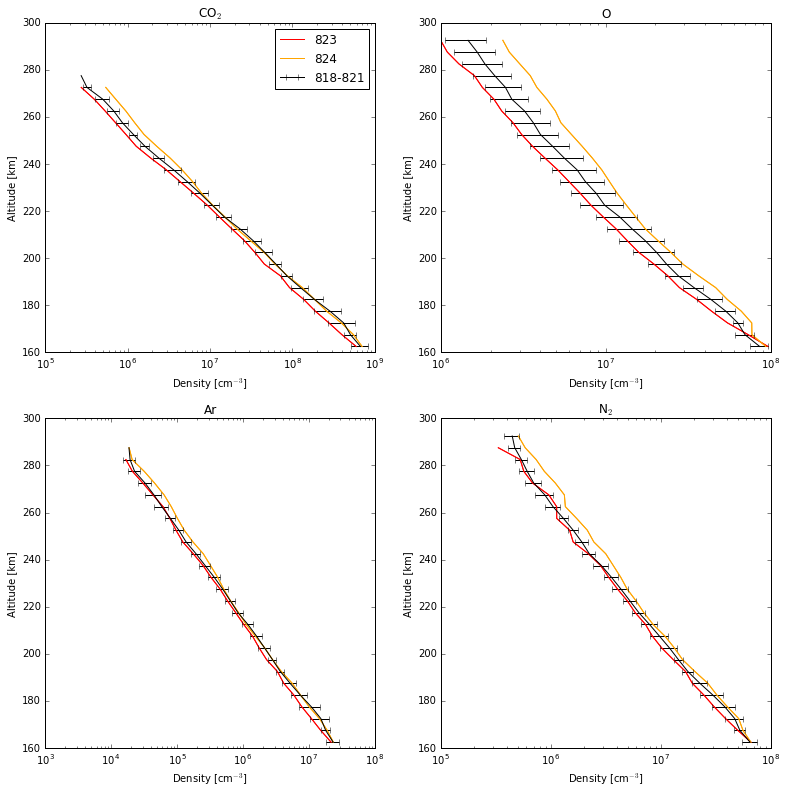

In [206]:
denb_fig, denb_ax = plt.subplots(2,2,figsize=(13,13))

denb_ax[0,0].plot(indmeans['abundance_CO2_mean_823'],indmeans['alt'],c='r',label='823')
denb_ax[0,0].plot(indmeans['abundance_CO2_mean_824'],indmeans['alt'],c='orange',label='824')
denb_ax[0,0].errorbar(b4means['abundance_CO2_mean'],b4means['bin_alt'],xerr=b4means['abundance_CO2_std'],c='k',label='818-821')

denb_ax[0,1].plot(indmeans['abundance_O_mean_823'],indmeans['alt'],c='r')
denb_ax[0,1].plot(indmeans['abundance_O_mean_824'],indmeans['alt'],c='orange')
denb_ax[0,1].errorbar(b4means['abundance_O_mean'],b4means['bin_alt'],xerr=b4means['abundance_O_std'],c='k',label='818-821')

denb_ax[1,0].plot(indmeans['abundance_Ar_mean_823'],indmeans['alt'],c='r')
denb_ax[1,0].plot(indmeans['abundance_Ar_mean_824'],indmeans['alt'],c='orange')
denb_ax[1,0].errorbar(b4means['abundance_Ar_mean'],b4means['bin_alt'],xerr=b4means['abundance_Ar_std'],c='k',label='818-821')

denb_ax[1,1].plot(indmeans['abundance_N2_mean_823'],indmeans['alt'],c='r')
denb_ax[1,1].plot(indmeans['abundance_N2_mean_824'],indmeans['alt'],c='orange')
denb_ax[1,1].errorbar(b4means['abundance_N2_mean'],b4means['bin_alt'],xerr=b4means['abundance_N2_std'],c='k',label='818-821')

# SHARED
for ax in denb_ax.flatten():
    # X-AXIS
    ax.set_xscale('log')
    ax.set_xlabel(r'Density [cm$^{-3}$]')

    # Y-AXIS
    ax.set_ylabel('Altitude [km]')
    ax.set_ylim(160,300)

# For legend
handles, labels = denb_ax[0,0].get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
    
# CO2
denb_ax[0,0].set_title(r'CO$_2$')
denb_ax[0,0].set_xlim(1.e+5,1.e+9)
denb_ax[0,0].legend(by_label.values(), by_label.keys(),numpoints=1)

# O
denb_ax[0,1].set_title(r'O')
denb_ax[0,1].set_xlim(1.e+6,1.e+8)

# Ar
denb_ax[1,0].set_title(r'Ar')
denb_ax[1,0].set_xlim(1.e+3,1.e+8)

# N2
denb_ax[1,1].set_title(r'N$_2$')
denb_ax[1,1].set_xlim(1.e+5,1.e+8)

denb_fig.subplots_adjust(hspace=0.2)

#plt.savefig('../cme_den_ba.png',dpi=500)

plt.show()

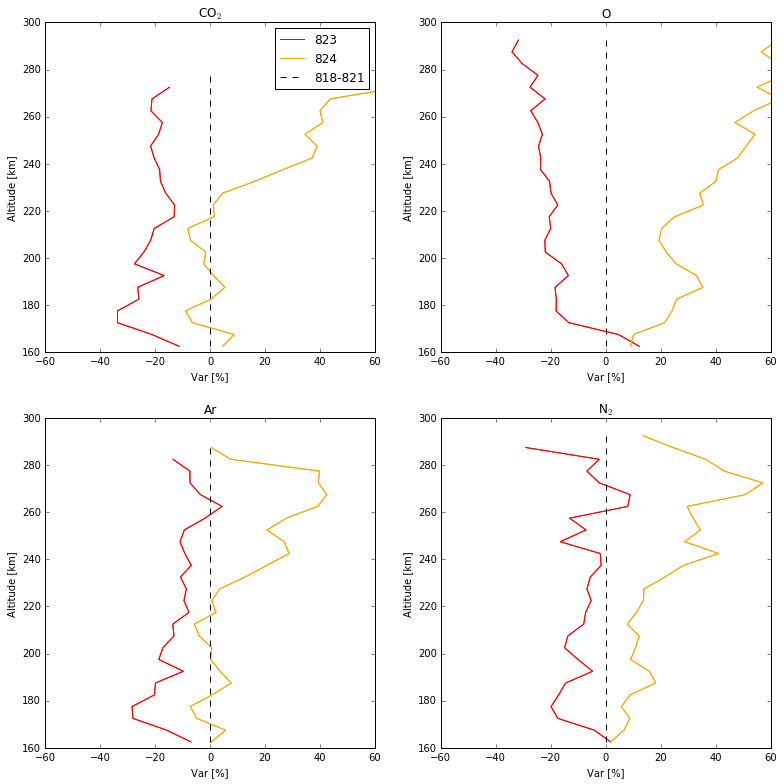

In [207]:
denb_fig, denb_ax = plt.subplots(2,2,figsize=(13,13))

denb_ax[0,0].plot((indmeans['abundance_CO2_mean_823']-b4means['abundance_CO2_mean'])/b4means['abundance_CO2_mean']*100,indmeans['alt'],c='r',label='823')
denb_ax[0,0].plot((indmeans['abundance_CO2_mean_824']-b4means['abundance_CO2_mean'])/b4means['abundance_CO2_mean']*100,indmeans['alt'],c='orange',label='824')
denb_ax[0,0].plot((b4means['abundance_CO2_mean']-b4means['abundance_CO2_mean'])/b4means['abundance_CO2_mean']*100,b4means['bin_alt'],c='k',ls='--',label='818-821')

denb_ax[0,1].plot((indmeans['abundance_O_mean_823']-b4means['abundance_O_mean'])/b4means['abundance_O_mean']*100,indmeans['alt'],c='r')
denb_ax[0,1].plot((indmeans['abundance_O_mean_824']-b4means['abundance_O_mean'])/b4means['abundance_O_mean']*100,indmeans['alt'],c='orange')
denb_ax[0,1].plot((b4means['abundance_O_mean']-b4means['abundance_O_mean'])/b4means['abundance_O_mean'],b4means['bin_alt'],c='k',ls='--',label='818-821')

denb_ax[1,0].plot((indmeans['abundance_Ar_mean_823']-b4means['abundance_Ar_mean'])/b4means['abundance_Ar_mean']*100,indmeans['alt'],c='r')
denb_ax[1,0].plot((indmeans['abundance_Ar_mean_824']-b4means['abundance_Ar_mean'])/b4means['abundance_Ar_mean']*100,indmeans['alt'],c='orange')
denb_ax[1,0].plot((b4means['abundance_Ar_mean']-b4means['abundance_Ar_mean'])/b4means['abundance_Ar_mean'],b4means['bin_alt'],c='k',ls='--',label='818-821')

denb_ax[1,1].plot((indmeans['abundance_N2_mean_823']-b4means['abundance_N2_mean'])/b4means['abundance_N2_mean']*100,indmeans['alt'],c='r')
denb_ax[1,1].plot((indmeans['abundance_N2_mean_824']-b4means['abundance_N2_mean'])/b4means['abundance_N2_mean']*100,indmeans['alt'],c='orange')
denb_ax[1,1].plot((b4means['abundance_N2_mean']-b4means['abundance_N2_mean'])/b4means['abundance_N2_mean']*100,b4means['bin_alt'],c='k',ls='--',label='818-821')

# SHARED
for ax in denb_ax.flatten():
    # X-AXIS
    #ax.set_xscale('log')
    ax.set_xlabel(r'Var [%]')
    ax.set_xlim(-60,60)

    # Y-AXIS
    ax.set_ylabel('Altitude [km]')
    ax.set_ylim(160,300)

# For legend
handles, labels = denb_ax[0,0].get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
    
# CO2
denb_ax[0,0].set_title(r'CO$_2$')
#denb_ax[0,0].set_xlim(1.e+5,1.e+9)
denb_ax[0,0].legend(by_label.values(), by_label.keys(),numpoints=1)

# O
denb_ax[0,1].set_title(r'O')
#denb_ax[0,1].set_xlim(1.e+6,1.e+8)

# Ar
denb_ax[1,0].set_title(r'Ar')
#denb_ax[1,0].set_xlim(1.e+3,1.e+8)

# N2
denb_ax[1,1].set_title(r'N$_2$')
#denb_ax[1,1].set_xlim(1.e+5,1.e+8)

denb_fig.subplots_adjust(hspace=0.2)

#plt.savefig('../cme_den_var',dpi=500)
plt.show()

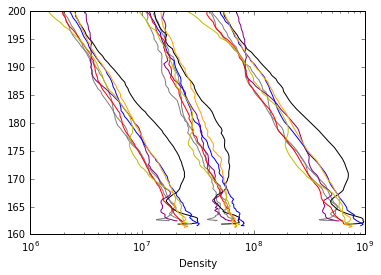

In [145]:
plt.figure()
for i,[orb,orbdata] in enumerate(df.groupby('orbit')):
    plt.plot(orbdata['abundance_Ar'],orbdata['alt'],c=cs[i])
    plt.plot(orbdata['abundance_N2'],orbdata['alt'],c=cs[i])
    plt.plot(orbdata['abundance_CO2'],orbdata['alt'],c=cs[i])
plt.xscale('log')
plt.xlabel('Density')
plt.xlim(1.e+6,1.e+9)
plt.ylim(160,200)
plt.show()

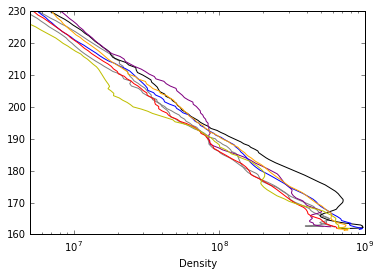

In [146]:
plt.figure()
for i,[orb,orbdata] in enumerate(df.groupby('orbit')):
    plt.plot(orbdata['abundance_CO2'],orbdata['alt'],c=cs[i])
plt.xscale('log')
plt.xlabel('Density')
plt.xlim(5.e+6,1.e+9)
plt.ylim(160,230)
plt.show()

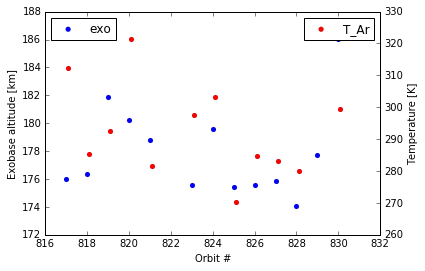

In [354]:
fig,ax = plt.subplots()
ax.scatter(df.orbit.unique(),exo_alts,lw=0.1,s=25,label='exo')
ax.set_ylabel('Exobase altitude [km]')
ax1 = plt.twinx()
ax1.scatter(df.orbit.unique()+0.1,t_Ar,c='r',lw=0.1,s=25,label='T_Ar')
ax1.set_ylabel('Temperature [K]')
ax.set_xlabel('Orbit #')
ax.legend(loc=2,scatterpoints=1)
ax1.legend(scatterpoints=1)
plt.show()

In [208]:
p4 = pd.concat(bindf)

In [355]:
bins = np.arange(140,300,5)
p4['bin'] = pd.cut(p4['alt'],bins)

p4bin = p4[['alt','abundance_CO2','abundance_Ar','abundance_N2']].groupby(p4['bin']).mean().reset_index()
p4bin.dropna(inplace=True)
p4bin.head()

p4bin_sd = p4[['alt','abundance_CO2','abundance_Ar','abundance_N2']].groupby(p4['bin']).std().reset_index()
p4bin_sd.dropna(inplace=True)
p4bin_sd.head()

,bin,alt,abundance_CO2,abundance_Ar,abundance_N2
4,"(160, 165]",0.860602,1.615624e+08,5.150135e+06,1.119016e+07
5,"(165, 170]",1.437422,8.139007e+07,2.597767e+06,6.309828e+06
6,"(170, 175]",1.457454,1.428208e+08,4.602023e+06,8.707658e+06
7,"(175, 180]",1.454085,9.938172e+07,3.607324e+06,9.244601e+06
8,"(180, 185]",1.474871,4.982322e+07,2.039337e+06,7.174947e+06


In [361]:
df1 = df[(df['orbit']==823)&(df['alt']<250)]
df2 = df[(df['orbit']==824)&(df['alt']<250)]
df3 = df[(df['orbit']==825)&(df['alt']<250)]
df4 = df[(df['orbit']==826)&(df['alt']<250)]
df5 = df[(df['orbit']==827)&(df['alt']<250)]

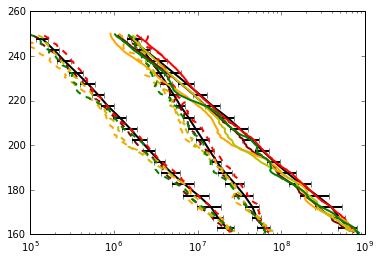

In [362]:
plt.figure()
plt.errorbar(p4bin['abundance_Ar'],p4bin['alt'],xerr=p4bin_sd['abundance_Ar'],c='k',lw=2,label='Ar')
plt.errorbar(p4bin['abundance_N2'],p4bin['alt'],xerr=p4bin_sd['abundance_N2'],c='k',lw=2,label='N2')
plt.errorbar(p4bin['abundance_CO2'],p4bin['alt'],xerr=p4bin_sd['abundance_CO2'],c='k',lw=2,label='CO2')

plt.plot(df1['abundance_Ar'],df1['alt'],color='darkred',lw=2,ls='--',label='Ar')
plt.plot(df1['abundance_N2'],df1['alt'],color='darkred',lw=2,ls='--',label='N2')
plt.plot(df1['abundance_CO2'],df1['alt'],color='darkred',lw=2,ls='-',label='CO2')

plt.plot(df2['abundance_Ar'],df2['alt'],color='r',lw=2,ls='--',label='Ar')
plt.plot(df2['abundance_N2'],df2['alt'],color='r',lw=2,ls='--',label='N2')
plt.plot(df2['abundance_CO2'],df2['alt'],color='r',lw=2,ls='-',label='CO2')

plt.plot(df3['abundance_Ar'],df3['alt'],color='orange',lw=2,ls='--',label='Ar')
plt.plot(df3['abundance_N2'],df3['alt'],color='orange',lw=2,ls='--',label='N2')
plt.plot(df3['abundance_CO2'],df3['alt'],color='orange',lw=2,ls='-',label='CO2')


plt.plot(df4['abundance_Ar'],df4['alt'],color='y',lw=2,ls='--',label='Ar')
plt.plot(df4['abundance_N2'],df4['alt'],color='y',lw=2,ls='--',label='N2')
plt.plot(df4['abundance_CO2'],df4['alt'],color='y',lw=2,ls='-',label='CO2')

plt.plot(df5['abundance_Ar'],df5['alt'],color='g',lw=2,ls='--',label='Ar')
plt.plot(df5['abundance_N2'],df5['alt'],color='g',lw=2,ls='--',label='N2')
plt.plot(df5['abundance_CO2'],df5['alt'],color='g',lw=2,ls='-',label='CO2')

plt.xscale('log')
plt.ylim(160,260)
plt.xlim(1.e+5,1.e+9)
plt.show()

In [285]:
p4exo = p4bin[p4bin['alt']<240].sort_values('alt',ascending=False)
#p4exo
exo_Ar_int(p4exo['abundance_CO2'],p4exo['alt'])

Has <5 points near tau=1


(nan, (nan, nan, nan, nan, nan))

In [331]:
p4 = p4.sort_values('alt',ascending=False)
p4['sg_Ar'] = rr.savgol_density(p4['abundance_Ar'],winsize=501,poly=2)
p4['sg_N2'] = rr.savgol_density(p4['abundance_N2'],winsize=501,poly=2)
p4['sg_CO2'] = rr.savgol_density(p4['abundance_CO2'],winsize=501,poly=2)

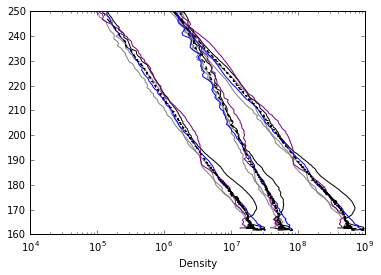

In [231]:
plt.figure()
for i,[orb,orbdata] in enumerate(p4[p4['alt']<250].groupby('orbit')):
    plt.plot(orbdata['abundance_Ar'],orbdata['alt'],c=cs[i])
    plt.plot(orbdata['abundance_N2'],orbdata['alt'],c=cs[i])
    plt.plot(orbdata['abundance_CO2'],orbdata['alt'],c=cs[i])
plt.plot(p4['sg_Ar'],p4['alt'],'k--')
plt.plot(p4['sg_N2'],p4['alt'],'k--')
plt.plot(p4['sg_CO2'],p4['alt'],'k--')
plt.xscale('log')
plt.xlabel('Density')
plt.show()

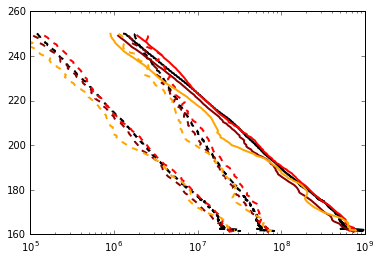

In [315]:
plt.figure()
#plt.plot(p4bin['abundance_Ar'],p4bin['alt'],'k--',lw=2,label='Ar')
#plt.plot(p4bin['abundance_N2'],p4bin['alt'],'k--',lw=2,label='N2')
#plt.plot(p4bin['abundance_CO2'],p4bin['alt'],'k',lw=2,label='CO2')

plt.plot(p4['sg_Ar'],p4['alt'],'k--',lw=2,label='Ar')
plt.plot(p4['sg_N2'],p4['alt'],'k--',lw=2,label='N2')
plt.plot(p4['sg_CO2'],p4['alt'],'k',lw=2,label='CO2')

plt.plot(df1['abundance_Ar'],df1['alt'],color='darkred',lw=2,ls='--',label='Ar')
plt.plot(df1['abundance_N2'],df1['alt'],color='darkred',lw=2,ls='--',label='N2')
plt.plot(df1['abundance_CO2'],df1['alt'],color='darkred',lw=2,ls='-',label='CO2')

plt.plot(df2['abundance_Ar'],df2['alt'],color='r',lw=2,ls='--',label='Ar')
plt.plot(df2['abundance_N2'],df2['alt'],color='r',lw=2,ls='--',label='N2')
plt.plot(df2['abundance_CO2'],df2['alt'],color='r',lw=2,ls='-',label='CO2')

plt.plot(df3['abundance_Ar'],df3['alt'],color='orange',lw=2,ls='--',label='Ar')
plt.plot(df3['abundance_N2'],df3['alt'],color='orange',lw=2,ls='--',label='N2')
plt.plot(df3['abundance_CO2'],df3['alt'],color='orange',lw=2,ls='-',label='CO2')

plt.xscale('log')
plt.ylim(160,260)
plt.xlim(1.e+5,1.e+9)
plt.show()

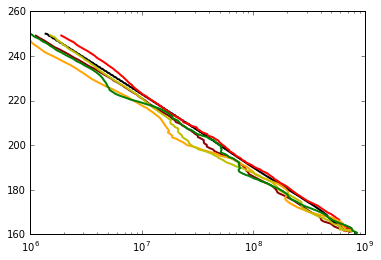

In [363]:
plt.figure()

plt.plot(p4['sg_CO2'],p4['alt'],'k',lw=2,label='CO2')

plt.plot(df1['abundance_CO2'],df1['alt'],color='darkred',lw=2,ls='-',label='CO2')

plt.plot(df2['abundance_CO2'],df2['alt'],color='r',lw=2,ls='-',label='CO2')

plt.plot(df3['abundance_CO2'],df3['alt'],color='orange',lw=2,ls='-',label='CO2')

plt.plot(df4['abundance_CO2'],df4['alt'],color='y',lw=2,ls='-',label='CO2')

plt.plot(df5['abundance_CO2'],df5['alt'],color='g',lw=2,ls='-',label='CO2')

plt.xscale('log')
plt.ylim(160,260)
plt.xlim(1.e+6,1.e+9)
plt.show()

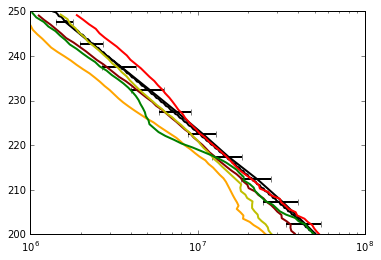

In [373]:
plt.figure()

plt.plot(p4['sg_CO2'],p4['alt'],'k',lw=2,label='CO2')
plt.errorbar(p4bin['abundance_CO2'],p4bin['alt'],xerr=p4bin_sd['abundance_CO2'],c='k',lw=2,label='CO2')

plt.plot(df1['abundance_CO2'],df1['alt'],color='darkred',lw=2,ls='-',label='CO2')

plt.plot(df2['abundance_CO2'],df2['alt'],color='r',lw=2,ls='-',label='CO2')

plt.plot(df3['abundance_CO2'],df3['alt'],color='orange',lw=2,ls='-',label='CO2')

plt.plot(df4['abundance_CO2'],df4['alt'],color='y',lw=2,ls='-',label='CO2')

plt.plot(df5['abundance_CO2'],df5['alt'],color='g',lw=2,ls='-',label='CO2')

plt.xscale('log')
plt.ylim(200,250)
plt.xlim(1.e+6,1.e+8)
plt.show()

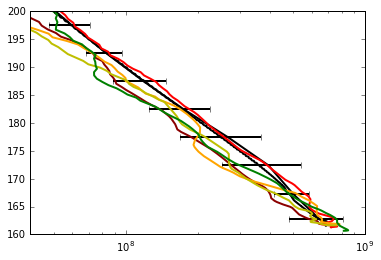

In [372]:
plt.figure()

plt.plot(p4['sg_CO2'],p4['alt'],'k',lw=2,label='CO2')
plt.errorbar(p4bin['abundance_CO2'],p4bin['alt'],xerr=p4bin_sd['abundance_CO2'],c='k',lw=2,label='CO2')

plt.plot(df1['abundance_CO2'],df1['alt'],color='darkred',lw=2,ls='-',label='CO2')

plt.plot(df2['abundance_CO2'],df2['alt'],color='r',lw=2,ls='-',label='CO2')

plt.plot(df3['abundance_CO2'],df3['alt'],color='orange',lw=2,ls='-',label='CO2')

plt.plot(df4['abundance_CO2'],df4['alt'],color='y',lw=2,ls='-',label='CO2')

plt.plot(df5['abundance_CO2'],df5['alt'],color='g',lw=2,ls='-',label='CO2')

plt.xscale('log')
plt.ylim(160,200)
plt.xlim(4.e+7,1.e+9)
plt.show()

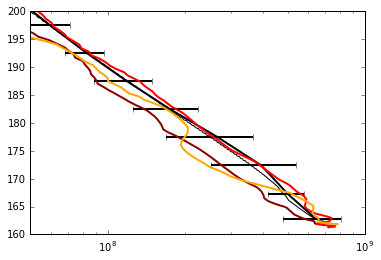

In [371]:
plt.figure()

plt.plot(p4['sg_CO2'],p4['alt'],'k',lw=1,label='CO2')


plt.plot(df1['abundance_CO2'],df1['alt'],color='darkred',lw=2,ls='-',label='CO2')

plt.plot(df2['abundance_CO2'],df2['alt'],color='r',lw=2,ls='-',label='CO2')

plt.plot(df3['abundance_CO2'],df3['alt'],color='orange',lw=2,ls='-',label='CO2')

plt.xscale('log')
plt.ylim(160,200)
plt.xlim(5.e+7,1.e+9)
plt.show()

In [286]:
p4exo = p4[p4['alt']<240].sort_values('alt',ascending=False)
#p4exo
exo_Ar_int(p4exo['sg_CO2'],p4exo['alt'])[0]

178.43019165390677

In [271]:
ta = sps.linregress(p4exo['alt'],np.log(p4exo['sg_Ar']))
tn = sps.linregress(p4exo['alt'],np.log(p4exo['sg_N2']))
tc = sps.linregress(p4exo['alt'],np.log(p4exo['sg_CO2']))

ta1 = sps.linregress(df1['alt'],np.log(df1['abundance_Ar']))
tn1 = sps.linregress(df1['alt'],np.log(df1['abundance_N2']))
tc1 = sps.linregress(df1['alt'],np.log(df1['abundance_CO2']))


ta2 = sps.linregress(df2['alt'],np.log(df2['abundance_Ar']))
tn2 = sps.linregress(df2['alt'],np.log(df2['abundance_N2']))
tc2 = sps.linregress(df2['alt'],np.log(df2['abundance_CO2']))

ta3 = sps.linregress(df3['alt'],np.log(df3['abundance_Ar']))
tn3 = sps.linregress(df3['alt'],np.log(df3['abundance_N2']))
tc3 = sps.linregress(df3['alt'],np.log(df3['abundance_CO2']))

In [273]:
print(x_to_T(ta[0],40))
print(x_to_T(tn[0],28))
print(x_to_T(tc[0],44))
print('\n')

print(x_to_T(ta1[0],40))
print(x_to_T(tn1[0],28))
print(x_to_T(tc1[0],44))
print('\n')

print(x_to_T(ta2[0],40))
print(x_to_T(tn2[0],28))
print(x_to_T(tc2[0],44))
print('\n')

print(x_to_T(ta3[0],40))
print(x_to_T(tn3[0],28))
print(x_to_T(tc3[0],44))

297.967737107
298.519528224
283.062837542


297.591140464
292.159636516
278.130194764


303.206855347
314.096898372
285.623903734


270.294346133
267.862804774
252.437844726
